In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 cd/content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [ ]:
!pip install tensorflow_model_optimization

     |████████████████████████████████| 174kB 3.3MB/s 


In [ ]:
import tensorflow as tf
import numpy as np
import math
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
# from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import model_from_json
from used_func import parameter_count
# import math
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [ ]:
batch_size = 32
num_classes = 10
num_epochs = 30

In [ ]:
# Data preprocessing and cleadning:
# input image dimensions
img_rows, img_cols = 28, 28

# Load MNIST dataset-
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print("\n'input_shape' which will be used = {0}\n".format(input_shape))


'input_shape' which will be used = (28, 28, 1)



In [ ]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [ ]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
print("\nDimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test = {1}".format(X_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train.shape = (60000, 28, 28, 1), y_train = (60000, 10)
X_test.shape = (10000, 28, 28, 1), y_test = (10000, 10)


In [ ]:
# Create training and testing datasets-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
train_dataset = train_dataset.shuffle(buffer_size = 20000, reshuffle_each_iteration = True).batch(batch_size = batch_size, drop_remainder = False)

In [ ]:
test_dataset = test_dataset.batch(batch_size=batch_size, drop_remainder=False)

In [ ]:
# Choose an optimizer and loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr = 0.0012)

In [ ]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')

In [ ]:
# The model is first trained without any pruning for 'num_epochs' epochs-
epochs = num_epochs

num_train_samples = X_train.shape[0]

end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * epochs

print("'end_step parameter' for this dataset =  {0}".format(end_step))

'end_step parameter' for this dataset =  56250


In [ ]:
# Specify the parameters to be used for layer-wise pruning, NO PRUNING is done here:
pruning_params_unpruned = {
    'pruning_schedule': sparsity.ConstantSparsity(
        target_sparsity=0.0, begin_step=0,
        end_step = end_step, frequency=100
    )
}

In [ ]:
l = tf.keras.layers

In [ ]:
# Specify the parameters to be used for layer-wise pruning
#p=0.2, %30 of the weights will be pruned in this setup
#we are setting begin_step=0 because we will prune the trained model

pruning_params_pruned = {
    'pruning_schedule': sparsity.ConstantSparsity(
        target_sparsity=0.3, begin_step=0,
        end_step = -1, frequency=100
    )
}

In [ ]:
def pruned_nn(pruning_params_conv, pruning_params_fc):
    """
    Function to define the architecture of a neural network model
    following LeNet-5 architecture for MNIST dataset and using
    provided parameter which are used to prune the model.
    
    
    Input: 'pruning_params' Python 3 dictionary containing parameters which are used for pruning
    Output: Returns designed and compiled neural network model
    """
    
    pruned_model = Sequential()
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 6, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'valid',
            input_shape=(28, 28, 1)
        ),
        **pruning_params_conv)
    )
       
    pruned_model.add(sparsity.prune_low_magnitude(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        ),
        **pruning_params_conv)
    )

    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 16, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'valid'
        ),
        **pruning_params_conv)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        ),
        **pruning_params_conv)
    )
   
    pruned_model.add(Flatten())
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = 120, activation='relu',
            kernel_initializer = tf.initializers.GlorotUniform()
        ),
        **pruning_params_fc)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = 84, activation='relu',
            kernel_initializer = tf.initializers.GlorotUniform()
        ),
        **pruning_params_fc)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = 10, activation='softmax'
        ),
        **pruning_params_fc)
    )
    

    # Compile pruned CNN-
    pruned_model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        # optimizer='adam',
        optimizer=tf.keras.optimizers.Adam(lr = 0.0012),
        metrics=['accuracy']
    )
    
    
    return pruned_model
    


In [ ]:
# Add a pruning step callback to peg the pruning step to the optimizer's 
# step. Also add a callback to add pruning summaries to tensorboard

callbacks = [
             sparsity.UpdatePruningStep(),
             # sparsity.PruningSummaries(log_dir = logdir, profile_batch=0),
             tf.keras.callbacks.EarlyStopping(
                 monitor='val_loss', patience = 3,
                 min_delta=0.001
             )
]

In [ ]:
# Add a pruning step callback to peg the pruning step to the optimizer's
# step. Also add a callback to add pruning summaries to tensorboard
callback = [
             sparsity.UpdatePruningStep(),
             # sparsity.PruningSummaries(log_dir = logdir, profile_batch=0),
             tf.keras.callbacks.EarlyStopping(
                 monitor='val_loss', patience = 3,
                 min_delta=0.001
             )
]

In [ ]:
# Initialize a CNN model-
orig_model = pruned_nn(pruning_params_unpruned, pruning_params_unpruned)

Instructions for updating:
Please use `layer.add_weight` method instead.


In [ ]:
orig_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d_4 (None, 26, 26, 6)         116       
_________________________________________________________________
prune_low_magnitude_max_pool (None, 13, 13, 6)         1         
_________________________________________________________________
prune_low_magnitude_conv2d_5 (None, 11, 11, 16)        1746      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 5, 5, 16)          1         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
prune_low_magnitude_dense_6  (None, 120)               96122     
_________________________________________________________________
prune_low_magnitude_dense_7  (None, 84)               

In [ ]:
# Save random weights-
orig_model.save_weights("2LeNet_5_MNIST_Random_Weights.h5", overwrite=True)

In [ ]:
from tensorflow.keras.models import load_model
orig_model.load_weights('LeNet_5_MNIST_Random_Weights.h5')

In [ ]:
# Strip model of it's pruning parameters
orig_model_stripped = sparsity.strip_pruning(orig_model)

In [ ]:
orig_model_stripped.save_weights('2LeNet_5_MNIST_Random_Weights_stripped.h5')

In [ ]:
# Get CNN summary-
orig_model_stripped.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 6)         60        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [ ]:
for layer in orig_model_stripped.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d (3, 3, 1, 6)
conv2d_1 (3, 3, 6, 16)


First Conv layer

In [ ]:
filters, biases = orig_model_stripped.layers[0].get_weights()

In [ ]:
print(filters.shape)
print(filters[0][0][0][3])
print(orig_model_stripped.layers[0].name)

(3, 3, 1, 6)
0.13284594
conv2d


In [ ]:
x = np.empty(shape=(6,9))
u=0
for i in range(6):
  p=0
  for j in range(3):
    for k in range(3):
      x[u][p] = (filters[j][k][0][i])
      #  print(filters[j][k][0][i])
      p=p+1 
  u=u+1       
print(x[3])

        

[ 0.13284594  0.08392861  0.27147278 -0.25486228 -0.1664923   0.20590797
 -0.26287442 -0.0366244  -0.23811343]


In [ ]:
# similarity matrix wsum
dot_product1 = np.empty(shape=(6,6))
for i in range (6):
  for j in range (6):
    dot_product1[i][j] = np.dot(x[i],x[j])

print (dot_product1)


[[ 0.22952969 -0.0692921  -0.00298396  0.13357937 -0.05130636 -0.07042669]
 [-0.0692921   0.32383303  0.04467189  0.12505903  0.1980263  -0.09904198]
 [-0.00298396  0.04467189  0.2408508   0.00354562  0.22278785 -0.00779146]
 [ 0.13357937  0.12505903  0.00354562  0.3606044   0.08916927 -0.08710967]
 [-0.05130636  0.1980263   0.22278785  0.08916927  0.40617774 -0.12694147]
 [-0.07042669 -0.09904198 -0.00779146 -0.08710967 -0.12694147  0.18847015]]


In [ ]:
# similarity matrix wmul
dot_product2 = np.empty(shape=(6,6))
for i in range (6):
  for j in range (6):
    dot_product2[i][j] = np.dot(abs(x[i]), abs(x[j]))

print (dot_product2)


[[0.22952969 0.21668758 0.16282975 0.21000829 0.23930447 0.15021579]
 [0.21668758 0.32383303 0.22022981 0.25890091 0.3052516  0.16176669]
 [0.16282975 0.22022981 0.2408508  0.24206771 0.2238899  0.14019392]
 [0.21000829 0.25890091 0.24206771 0.3606044  0.34338907 0.22289962]
 [0.23930447 0.3052516  0.2238899  0.34338907 0.40617774 0.20352294]
 [0.15021579 0.16176669 0.14019392 0.22289962 0.20352294 0.18847015]]


In [ ]:
e=dot_product1[0][0]/dot_product2[0][0]
print(e)

1.0


In [ ]:
a = []
for i in range (6):
  for j in range (6):
    a.append(dot_product1[i][j]/dot_product2[i][j])

print(np.array(a))
len(a)


[ 1.         -0.31977882 -0.01832564  0.63606712 -0.21439784 -0.46883677
 -0.31977882  1.          0.20284215  0.48303821  0.64873142 -0.612252
 -0.01832564  0.20284215  1.          0.0146472   0.99507774 -0.05557632
  0.63606712  0.48303821  0.0146472   1.          0.25967418 -0.39080225
 -0.21439784  0.64873142  0.99507774  0.25967418  1.         -0.6237207
 -0.46883677 -0.612252   -0.05557632 -0.39080225 -0.6237207   1.        ]


36

In [ ]:
print(x)

[[-0.14853045  0.15485695  0.08538434 -0.21020025 -0.10585156  0.17156577
   0.07031035 -0.28328329 -0.07861778]
 [ 0.21257988 -0.25795475  0.09758279  0.01528242  0.21965209  0.28693125
  -0.11141749  0.13122016 -0.20527312]
 [-0.00222123  0.23137197 -0.2830753   0.0748069   0.12411854  0.22880402
  -0.16213186  0.06521577 -0.05734679]
 [ 0.13284594  0.08392861  0.27147278 -0.25486228 -0.1664923   0.20590797
  -0.26287442 -0.0366244  -0.23811343]
 [ 0.2480711   0.18378502 -0.06358118  0.30159637  0.19603029  0.29068175
  -0.23049837  0.00945449 -0.19928861]
 [ 0.05576569  0.00252622 -0.17958859 -0.18793198  0.0038465  -0.19684312
  -0.04708686  0.1022442   0.25758573]]


In [ ]:
dot_product = np.empty(shape=(6,6))
for i in range (6):
  for j in range (6):
    if i == j:
      dot_product[i][j]=0
      continue
    dot_product[i][j] = np.dot(x[i],x[j])
     

In [ ]:
print(dot_product)

[[ 0.         -0.0692921  -0.00298396  0.13357937 -0.05130636 -0.07042669]
 [-0.0692921   0.          0.04467189  0.12505903  0.1980263  -0.09904198]
 [-0.00298396  0.04467189  0.          0.00354562  0.22278785 -0.00779146]
 [ 0.13357937  0.12505903  0.00354562  0.          0.08916927 -0.08710967]
 [-0.05130636  0.1980263   0.22278785  0.08916927  0.         -0.12694147]
 [-0.07042669 -0.09904198 -0.00779146 -0.08710967 -0.12694147  0.        ]]


In [ ]:
filters, biases = orig_model_stripped.layers[2].get_weights()

In [ ]:
print(filters.shape)

(3, 3, 6, 16)


In [ ]:
x = np.empty(shape=(16,9))
u=0
for i in range(16):
  p=0
  for j in range(3):
    for k in range(3):
      x[u][p] = (filters[j][k][0][i])
      #  print(filters[j][k][0][i])
      p=p+1 
  u=u+1       
print(x[4])

        

[ 0.09718907  0.11855274 -0.17238611 -0.00509436 -0.12918457 -0.08536953
 -0.07800637  0.15302607  0.0887652 ]


In [ ]:
print(x)

[[ 0.04437733  0.07581753 -0.10953792 -0.05711354 -0.16949855  0.00311154
   0.10530072  0.11761606 -0.08597784]
 [-0.16401908  0.08326411  0.01551184  0.11349818  0.02050245  0.09421328
   0.05727583  0.09441575  0.06304143]
 [-0.02668084 -0.11888543 -0.11821423 -0.15121114 -0.13956995 -0.09524076
  -0.02647656  0.14596322 -0.00376585]
 [-0.15197226 -0.16185297 -0.1162073  -0.09883288 -0.08650377 -0.01475593
   0.06519604  0.03884423 -0.0435688 ]
 [ 0.09718907  0.11855274 -0.17238611 -0.00509436 -0.12918457 -0.08536953
  -0.07800637  0.15302607  0.0887652 ]
 [ 0.16684139 -0.09321386 -0.00024615 -0.10035369  0.12575856  0.05205093
  -0.0103579  -0.05953676 -0.03177869]
 [-0.13001525  0.08865365  0.08222163 -0.08945391 -0.04266909 -0.05415805
  -0.01876101 -0.06226058 -0.01406889]
 [-0.08089389 -0.03157537  0.15125111  0.11033052 -0.0380697   0.00451258
  -0.0670973   0.05570097 -0.09174158]
 [-0.0733099  -0.16397828 -0.14128631  0.17308244  0.16640472 -0.16908431
  -0.09322996  0.15475

In [ ]:
dot_product = np.empty(shape=(16,16))
for i in range (16):
  for j in range (16):
    # if i == j:
    #   dot_product[i][j]=0
    #   continue
    dot_product[i][j] = np.dot(x[i],x[j])
     

In [ ]:
# similarity matrix wsum
dot_product1 = np.empty(shape=(16,16))
for i in range (16):
  for j in range (16):
    dot_product1[i][j] = np.dot(x[i],x[j])

print (dot_product1)


[[ 8.40315649e-02 -6.13424829e-04  4.94514784e-02  2.91545831e-02
   5.62584629e-02 -2.04195969e-02 -3.97053135e-03 -1.50124436e-02
  -2.36145868e-02  2.09936930e-02 -5.52061847e-02 -2.62634391e-02
  -9.21224973e-03 -5.49022511e-02 -2.72413237e-02  4.88632864e-02]
 [-6.13424829e-04  7.24231945e-02 -2.43257469e-02 -7.88535924e-05
  -4.43736422e-03 -4.72559124e-02  6.01211862e-03  2.07846409e-02
   7.57029639e-03 -1.01899992e-03 -1.73330548e-02  1.47865475e-02
  -1.44167776e-03  4.18445940e-02 -4.83840417e-02 -2.52609463e-03]
 [ 4.94514784e-02 -2.43257469e-02  1.02256054e-01  6.95651253e-02
   5.46897235e-02 -8.97175314e-03 -6.88719305e-04 -1.35151816e-02
   3.02147852e-02  3.06983078e-02 -1.96814072e-02 -1.29123225e-02
   1.45305585e-02 -6.09723902e-02 -3.67194154e-02  5.34070444e-02]
 [ 2.91545831e-02 -7.88535924e-05  6.95651253e-02  8.79223047e-02
  -3.99640249e-03 -1.35715176e-02  6.15763567e-03 -6.06373257e-03
   2.84869326e-02  7.14779733e-03 -4.40241222e-02 -1.74961642e-02
   1.63

In [ ]:
# similarity matrix wsum
dot_product2 = np.empty(shape=(16,16))
for i in range (16):
  for j in range (16):
    dot_product1[i][j] = np.dot(abs(x[i]),abs(x[j]))

print (dot_product2)


[[ 1.74817722e-315  6.93952399e-310  0.00000000e+000  0.00000000e+000
   0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000  0.00000000e+000  6.93952807e-310 -5.77997053e+276
   0.00000000e+000  0.00000000e+000  6.93952811e-310  5.72042127e-110]
 [ 0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
   6.93952669e-310 -9.33019824e-123  0.00000000e+000  0.00000000e+000]
 [ 0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
   6.93952669e-310  2.91371226e-148  0.00000000e+000  0.00000000e+000
   0.00000000e+000  0.00000000e+000  6.93952786e-310  1.81800108e-093
   0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000]
 [ 0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
   6.93952735e-310 -1.70095008e+296  6.93952669e-310  9.25381738e+265
   0.00000000e+00

In [ ]:
a = []
for i in range (16):
  for j in range (16):
    a.append(dot_product1[i][j]/dot_product2[i][j])

print(a)
len(a)

[inf, 6.930946631761412e+307, inf, inf, inf, inf, inf, inf, inf, inf, 9.804997020717384e+307, -9.837067897160145e-279, inf, inf, 1.0471225913127775e+308, 1.3633520705585635e+108, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 6.913398768102707e+307, -9.235822794996669e+120, inf, inf, inf, inf, inf, inf, 1.2786583361209114e+308, 2.13921305852961e+146, inf, inf, inf, inf, 8.215564035794778e+307, 3.6324005798126595e+91, inf, inf, inf, inf, inf, inf, inf, inf, 1.1791308989448499e+308, -3.904183639890304e-298, 8.825972607925038e+307, 6.460029109746243e-268, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 1.6514272813687551e+308, -4.725198894215721e-70, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 8.358721058165017e+307, 4.7502897256318965e+125, inf, inf, 7.018631804591735e+307, -1.7445393388411735e-175, inf, inf, inf, inf, inf, inf, inf, inf, 8.188481263887498e+307, 4.0503

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


256

In [ ]:
print(dot_product)

[[ 8.40315649e-02 -6.13424829e-04  4.94514784e-02  2.91545831e-02
   5.62584629e-02 -2.04195969e-02 -3.97053135e-03 -1.50124436e-02
  -2.36145868e-02  2.09936930e-02 -5.52061847e-02 -2.62634391e-02
  -9.21224973e-03 -5.49022511e-02 -2.72413237e-02  4.88632864e-02]
 [-6.13424829e-04  7.24231945e-02 -2.43257469e-02 -7.88535924e-05
  -4.43736422e-03 -4.72559124e-02  6.01211862e-03  2.07846409e-02
   7.57029639e-03 -1.01899992e-03 -1.73330548e-02  1.47865475e-02
  -1.44167776e-03  4.18445940e-02 -4.83840417e-02 -2.52609463e-03]
 [ 4.94514784e-02 -2.43257469e-02  1.02256054e-01  6.95651253e-02
   5.46897235e-02 -8.97175314e-03 -6.88719305e-04 -1.35151816e-02
   3.02147852e-02  3.06983078e-02 -1.96814072e-02 -1.29123225e-02
   1.45305585e-02 -6.09723902e-02 -3.67194154e-02  5.34070444e-02]
 [ 2.91545831e-02 -7.88535924e-05  6.95651253e-02  8.79223047e-02
  -3.99640249e-03 -1.35715176e-02  6.15763567e-03 -6.06373257e-03
   2.84869326e-02  7.14779733e-03 -4.40241222e-02 -1.74961642e-02
   1.63

In [ ]:
# Train unpruned Neural Network-
history_orig = orig_model.fit(
    x = X_train, y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    verbose = 1,
    callbacks = callbacks,
    validation_data = (X_test, y_test),
    shuffle = True
)


Epoch 1/30
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1768 - accuracy: 0.9466 - val_loss: 0.0628 - val_accuracy: 0.9795
Epoch 2/30
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0630 - accuracy: 0.9809 - val_loss: 0.0445 - val_accuracy: 0.9852
Epoch 3/30
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0460 - accuracy: 0.9852 - val_loss: 0.0463 - val_accuracy: 0.9853
Epoch 4/30
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0370 - accuracy: 0.9882 - val_loss: 0.0396 - val_accuracy: 0.9869
Epoch 5/30
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0287 - accuracy: 0.9912 - val_loss: 0.0380 - val_accuracy: 0.9882
Epoch 6/30
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0240 - accuracy: 0.9924 - val_loss: 0.0426 - val_accuracy: 0.9862
Epoch 7/30
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0189 - accuracy: 0.9937 - val_loss: 0.0397 -

In [ ]:
# Evaluate original unpruned trained model on testing dataset-
score_orig_model = orig_model.evaluate(X_test, y_test, verbose=0)

print("\nOriginal & UNPRUNED model metrics on testing dataset:")
print("loss = {0:.4f} and accuracy = {1:.4f}\n".format(score_orig_model[0], score_orig_model[1]))


Original & UNPRUNED model metrics on testing dataset:
loss = 0.0455 and accuracy = 0.9876



In [ ]:
# Trained parameters of neural network AFTER training UNPRUNED model-
orig_model.save_weights("2LeNet_5_MNIST_Winning_Ticket_Trained_Weights.h5", overwrite = True)

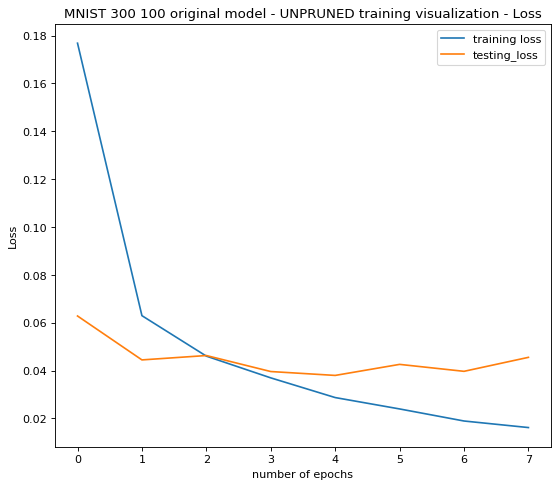

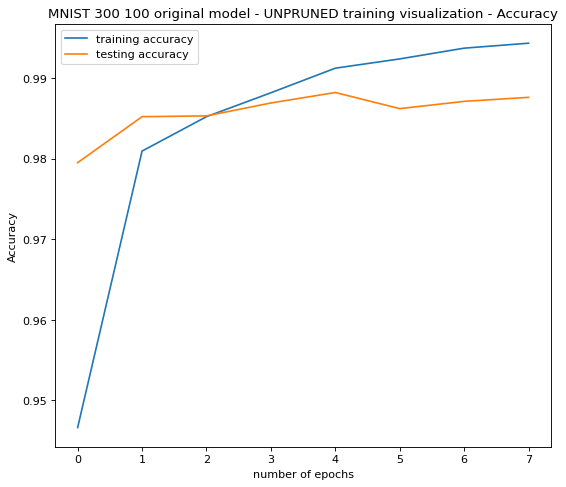

In [ ]:
# Visualize the training of the neural network (scalar metrics):
fig=plt.figure(figsize=(8, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history_orig.history['loss'], label = 'training loss')
plt.plot(history_orig.history['val_loss'], label = 'testing_loss')

plt.title("MNIST 300 100 original model - UNPRUNED training visualization - Loss")
plt.xlabel("number of epochs")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()

fig=plt.figure(figsize=(8, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history_orig.history['accuracy'], label = 'training accuracy')
plt.plot(history_orig.history['val_accuracy'], label = 'testing accuracy')

plt.title("MNIST 300 100 original model - UNPRUNED training visualization - Accuracy")
plt.xlabel("number of epochs")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')  # 'center right'
plt.show()


In [ ]:
orig_model_trained=parameter_count('orig_model_trained',orig_model)


In orig_model_trained Number of nonzero parameters in each layer are: 

54
6
864
16
48000
120
10080
84
840
10

Total number of trainable parameters = 60074



In [ ]:
orig_model_trained = sparsity.strip_pruning(orig_model)

In [ ]:
filters, biases = orig_model_trained.layers[0].get_weights()

In [ ]:
print(filters.shape)

(3, 3, 1, 6)


In [ ]:
x = np.empty(shape=(6,9))
u=0
for i in range(6):
  p=0
  for j in range(3):
    for k in range(3):
      x[u][p] = (filters[j][k][0][i])
      #  print(filters[j][k][0][i])
      p=p+1 
  u=u+1       
print(x[4])

        

[ 0.30296701  0.40787777  0.00521735  0.33774585  0.28836015  0.17907768
 -0.14144625 -0.02803118 -0.35024741]


In [ ]:
dot_product = np.empty(shape=(6,6))
for i in range (6):
  for j in range (6):
    if i == j:
      dot_product[i][j]=0
      continue
    dot_product[i][j] = np.dot(x[i],x[j])
     

In [ ]:
print(dot_product)

[[ 0.         -0.00320974  0.1645022   0.94018657  0.28462931 -0.75171494]
 [-0.00320974  0.          0.08382403  0.07550877  0.19099935 -0.07216009]
 [ 0.1645022   0.08382403  0.          0.12936169  0.18721341  0.026445  ]
 [ 0.94018657  0.07550877  0.12936169  0.          0.45852119 -0.83837335]
 [ 0.28462931  0.19099935  0.18721341  0.45852119  0.         -0.58891398]
 [-0.75171494 -0.07216009  0.026445   -0.83837335 -0.58891398  0.        ]]


In [ ]:
# Instantiate a Nueal Network model to be pruned using parameters from above-
pruned_model = pruned_nn(pruning_params_pruned,pruning_params_pruned)

In [ ]:
# Load weights from original trained and unpruned model-
pruned_model.load_weights("2LeNet_5_MNIST_Winning_Ticket_Trained_Weights.h5")

In [ ]:
# Train pruned NN
history_pruned = pruned_model.fit(
    x = X_train, y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    verbose = 1,
    callbacks = callbacks,
    validation_data = (X_test, y_test),
    shuffle = True
)


Epoch 1/30
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0122 - accuracy: 0.9960 - val_loss: 0.0420 - val_accuracy: 0.9891
Epoch 2/30
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0076 - accuracy: 0.9976 - val_loss: 0.0523 - val_accuracy: 0.9863
Epoch 3/30
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0085 - accuracy: 0.9972 - val_loss: 0.0556 - val_accuracy: 0.9871
Epoch 4/30
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0064 - accuracy: 0.9979 - val_loss: 0.0543 - val_accuracy: 0.9892


In [ ]:
# Save weights of PRUNED and Trained model BEFORE stripping-
pruned_model.save_weights("2LeNet_5_MNIST_Winning_Ticket_Trained_Weights_Pruned.h5", overwrite = True)

In [ ]:
# Strip the pruning wrappers from pruned model-
pruned_model_stripped = sparsity.strip_pruning(pruned_model)

In [ ]:
# we need to load the original weights to the model before we continue

orig_model_stripped.load_weights('2LeNet_5_MNIST_Random_Weights_stripped.h5')

orig_model_stripped_params=parameter_count('orig_model_stripped',orig_model_stripped)


In orig_model_stripped Number of nonzero parameters in each layer are: 

54
0
864
0
48000
0
10080
0
840
0

Total number of trainable parameters = 59838



In [ ]:
# Instantiate a new neural network model for which, the mask is to be created,

mask_model = pruned_nn(pruning_params_unpruned,pruning_params_unpruned)

In [ ]:
# Load weights of PRUNED model-
mask_model.load_weights("2LeNet_5_MNIST_Winning_Ticket_Trained_Weights_Pruned.h5")

In [ ]:
# Strip the model of its pruning parameters-
mask_model_stripped = sparsity.strip_pruning(mask_model)

In [ ]:
# For each layer, for each weight which is 0, leave it, as is.
# And for weights which survive the pruning,reinitialize it to ONE (1)-

for wts in mask_model_stripped.trainable_weights:
    wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))

In [ ]:
mask_model_stripped.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 6)         60        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_7 (Dense)              (None, 84)               

In [ ]:
filters, biases = mask_model_stripped.layers[0].get_weights()

In [ ]:
print(filters.shape)

(3, 3, 1, 6)


In [ ]:
x = np.empty(shape=(6,9))
u=0
for i in range(6):
  p=0
  for j in range(3):
    for k in range(3):
      x[u][p] = (filters[j][k][0][i])
      #  print(filters[j][k][0][i])
      p=p+1 
  u=u+1       
print(x[4])

        

[1. 1. 0. 1. 1. 1. 0. 0. 1.]


In [ ]:
print(x)

[[0. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 0. 0. 1. 1. 0. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 0. 0. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 0. 0. 1.]
 [0. 1. 1. 1. 0. 0. 1. 1. 1.]]


In [ ]:
dot_product = np.empty(shape=(6,6))
for i in range (6):
  for j in range (6):
    if i == j:
      dot_product[i][j]=0
      continue
    dot_product[i][j] = np.dot(x[i],x[j])
     

In [ ]:
print(dot_product)

[[0. 3. 6. 6. 4. 6.]
 [3. 0. 3. 4. 4. 2.]
 [6. 3. 0. 5. 5. 5.]
 [6. 4. 5. 0. 4. 5.]
 [4. 4. 5. 4. 0. 3.]
 [6. 2. 5. 5. 3. 0.]]


In [ ]:
filters, biases =  mask_model_stripped.layers[2].get_weights()

In [ ]:
conv2_pruned = np.empty(shape=(16,9))
u=0
for i in range(16):
  p=0
  for j in range(3):
    for k in range(3):
      conv2_pruned[u][p] = (filters[j][k][0][i])
      #  print(filters[j][k][0][i])
      p=p+1 
  u=u+1       
print(conv2_pruned[4])

        

[1. 1. 1. 0. 0. 1. 1. 1. 0.]


In [ ]:
print(conv2_pruned)

[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 1. 0. 1. 1. 1. 1.]
 [1. 0. 1. 0. 0. 1. 0. 1. 0.]
 [1. 1. 0. 0. 1. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0. 1. 1. 1. 0.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 0. 1. 1. 0. 1.]
 [0. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 0. 1. 1. 1.]
 [0. 1. 1. 1. 1. 0. 0. 1. 1.]
 [1. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 0. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1.]]


In [ ]:
dot_product = np.empty(shape=(16,16))
for i in range (16):
  for j in range (16):
    # if i == j:
    #   dot_product[i][j]=0
    #   continue
    dot_product[i][j] = np.dot(x[i],x[j])
     

In [ ]:
print(dot_product)

[[ 8.40315649e-02 -6.13424829e-04  4.94514784e-02  2.91545831e-02
   5.62584629e-02 -2.04195969e-02 -3.97053135e-03 -1.50124436e-02
  -2.36145868e-02  2.09936930e-02 -5.52061847e-02 -2.62634391e-02
  -9.21224973e-03 -5.49022511e-02 -2.72413237e-02  4.88632864e-02]
 [-6.13424829e-04  7.24231945e-02 -2.43257469e-02 -7.88535924e-05
  -4.43736422e-03 -4.72559124e-02  6.01211862e-03  2.07846409e-02
   7.57029639e-03 -1.01899992e-03 -1.73330548e-02  1.47865475e-02
  -1.44167776e-03  4.18445940e-02 -4.83840417e-02 -2.52609463e-03]
 [ 4.94514784e-02 -2.43257469e-02  1.02256054e-01  6.95651253e-02
   5.46897235e-02 -8.97175314e-03 -6.88719305e-04 -1.35151816e-02
   3.02147852e-02  3.06983078e-02 -1.96814072e-02 -1.29123225e-02
   1.45305585e-02 -6.09723902e-02 -3.67194154e-02  5.34070444e-02]
 [ 2.91545831e-02 -7.88535924e-05  6.95651253e-02  8.79223047e-02
  -3.99640249e-03 -1.35715176e-02  6.15763567e-03 -6.06373257e-03
   2.84869326e-02  7.14779733e-03 -4.40241222e-02 -1.74961642e-02
   1.63